# Goal
* Model data using an MLP
* Use the torch optimizer Adam instead of our simple optimizer we used in past videos. 

In [173]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [174]:
%matplotlib inline

In [175]:
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, _input):
        return mish(_input)
    
def make_batch(x): return x[:,None]

def debatch(x, detach = True):
    x =  x.squeeze()
    if detach: x = x.detach()
    return x

def make_mlp(n = 20, layers_count = 3, act = Mish):
    layers = []
    layers.append(nn.Linear(1,n))
    layers.append(act())
    for i in range(layers_count -2):
        layers.append(nn.Linear(n,n))
        layers.append(act())
    layers.append(nn.Linear(n,1))
    mlp = nn.Sequential(*layers)
    return mlp

class Stepper:
    clear_grad = True
    def __call__(self,my_mlp,xb, yb, lr = 1e-1):
        yprime = my_mlp(xb)
        loss = F.mse_loss(yb,yprime )
        loss.backward()
        for name, param in my_mlp.named_parameters():
            param.data = param.data - param.grad*lr
        if self.clear_grad: my_mlp.zero_grad()
        self.yprime = yprime
        return yprime.squeeze().detach()

In [176]:
do_step = Stepper()

In [177]:
x = torch.linspace(-1,1, 50)

In [ ]:
from math import pi

# x = torch.linspace(-pi, pi, 100)
# yv  = torch.sin(2*pi*x)
yv = (x+0.2)*(x-0.9)*torch.sin(math.pi*2*x)
plt.plot(x,yv)
plt.grid()

In [178]:
def my_fun(x):
    num = x**2 
    den = (x+0.2)*(x-0.9)*torch.sin(6*x)
    y = num/den
    
#     y = x**2
#     dydx = 2*x
#     d2yd2x = x*0+2
    return y

In [179]:
y = my_fun(x)

(-10.0, 10.0)

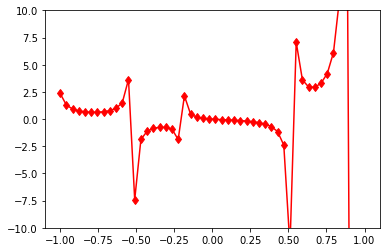

In [180]:
plt.plot(x,y, "rd-")
plt.ylim([-10,10])

In [181]:
xb, yb = [make_batch(z) for z in [x,y]]

In [182]:
mlp = make_mlp(act = Mish)

In [183]:
yprime_mlp = mlp(xb)

In [184]:
# yprime_debatch_mlp = debatch(yprime_mlp)

# plt.plot(x,y, "rd-", label = "true")
# plt.plot(x,yprime_debatch_mlp, "gs-", label = "MLP")
# plt.ylim([-10,10])

In [185]:
for i in range(1000):
    yprime_debatch_mlp = do_step(mlp, xb, yb, lr = 3e-2)

(-30.0, 30.0)

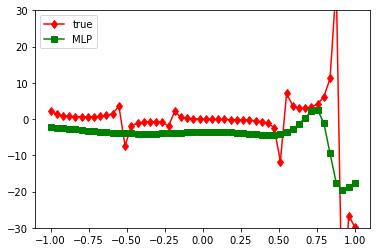

In [186]:
plt.plot(x,y, "rd-", label = "true")
plt.plot(x,yprime_debatch_mlp, "gs-", label = "MLP")
plt.legend()
r = 30
plt.ylim([-r,r])

In [187]:
# xb.requires_grad = True
# yprime = mlp(xb)

# dydx = torch.autograd.grad(yprime.sum(), xb, create_graph=True)[0]

# d2yd2x = torch.autograd.grad(dydx.sum(), xb, create_graph=True)[0]

# # y, dydx_analytical, d2yd2x_analytical 



# plt.plot(x,dydx_analytical, "rd-", label = "true dy/dx")
# plt.plot(x,debatch(dydx), "gs-", label = "MLP dy/dx")
# plt.legend()

# plt.plot(x,d2yd2x_analytical, "rd-", label = "true d2y/d2x")
# plt.plot(x,debatch(d2yd2x), "gs-", label = "MLP d2y/d2x")
# plt.legend()

In [188]:
from  fastcore.basics import *
from torch.optim import Adam

In [189]:
class Stepper_v2:
    """Uses Adam optimizer rather than just SGD. Adam is much better. """
    def __init__(self, my_mlp, xb, yb, lr = 0.001):
        store_attr("my_mlp, xb, yb, lr")
        
    def do_epochs(self, epochs, lr = None):
        lr = self.lr if lr is None else lr
        self.optimizer = Adam(self.my_mlp.parameters(), lr = lr)
        self.loss_list = []
        for i in range(epochs):
            self.optimizer.zero_grad()
            self.yprime = self.my_mlp(self.xb)
            self.loss = F.mse_loss(self.yb,self.yprime )
            self.loss.backward()
            self.optimizer.step()
            self.loss_list.append(self.loss.detach())
            
   

In [190]:
mlp = make_mlp(act = Mish)

In [191]:
stepper = Stepper_v2(mlp, xb, yb, lr = 3e-2)

In [192]:
stepper.do_epochs(1000)

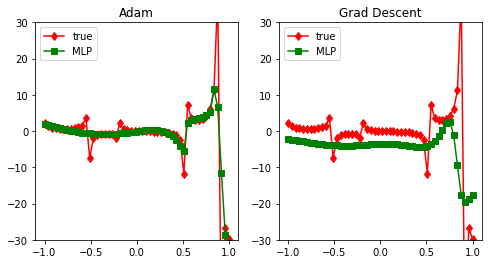

In [193]:
yprime_out = debatch( stepper.yprime.detach())

fig, ax  = plt.subplots(1,2, figsize = (8,4))

r = 30
for i, (y_from_model, title) in enumerate(zip([yprime_out, yprime_debatch_mlp], ['Adam', "Grad Descent"])):
    ax[i].plot(x,y, "rd-", label = "true")
    ax[i].plot(x,y_from_model, "gs-", label = "MLP")
    ax[i].legend()
    ax[i].set_ylim([-r,r])
    ax[i].set_title(title)

# ax[0].plot(x,y, "rd-", label = "true")
# ax[0].plot(x,yprime_out, "gs-", label = "MLP")
# ax[0].legend()
# r = 30
# ax[0].set_ylim([-r,r])
# ax[0].set_title("Adam")